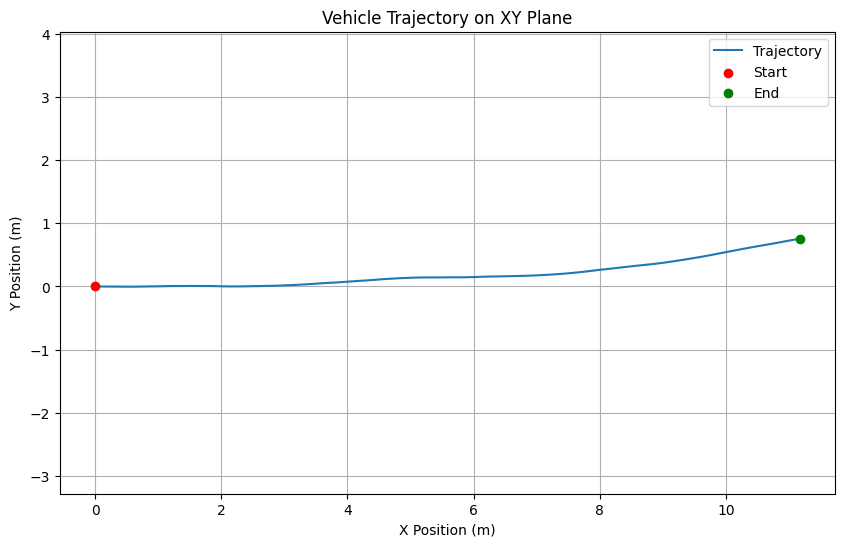

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def state_space_model(x, u):
    """
    Nonlinear state-space model.
    x: [x, y, theta, v]
    u: [u1 (acceleration), u2 (angular velocity)]
    Returns: dx/dt
    """
    x_pos, y_pos, theta, v = x
    u1, u2 = u
    dx = np.zeros_like(x)
    dx[0] = v * np.cos(theta)
    dx[1] = v * np.sin(theta)
    dx[2] = u2
    dx[3] = u1
    return dx
    
dt = 0.1
num_steps = 100
x = np.array([0.0, 0.0, 0.0, 1.0])
x_history = [x[0]]
y_history = [x[1]]

for step in range(num_steps):
    u1 = np.random.uniform(-0.5, 0.5)
    u2 = np.random.uniform(-0.2, 0.2)
    u = np.array([u1, u2])
    
    dx = state_space_model(x, u)
    x = x + dx * dt
    
    x_history.append(x[0])
    y_history.append(x[1])
    
plt.figure(figsize=(10, 6))
plt.plot(x_history, y_history, label="Trajectory")
plt.scatter(x_history[0], y_history[0], color='red', label="Start", zorder=5)
plt.scatter(x_history[-1], y_history[-1], color='green', label="End", zorder=5)
plt.title("Vehicle Trajectory on XY Plane")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.legend()
plt.grid()
plt.axis('equal')
plt.show()


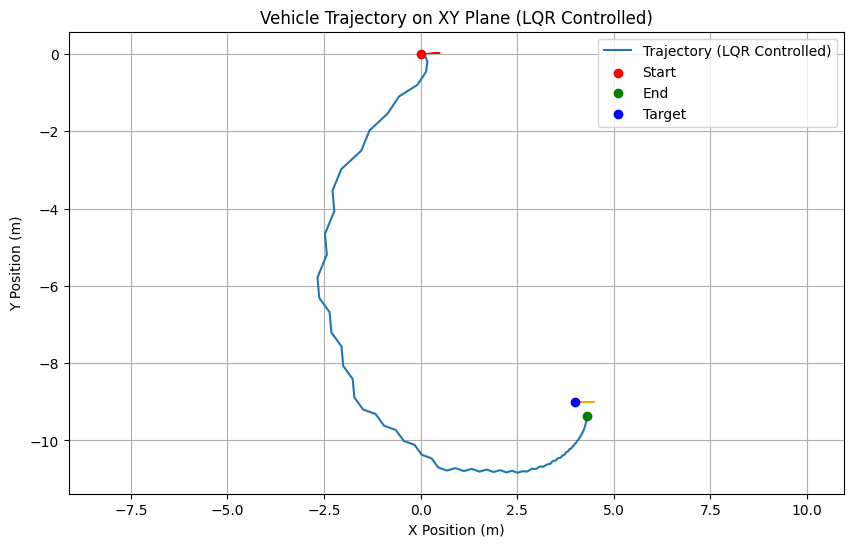

In [6]:
import numpy as np
from scipy.linalg import expm, solve_continuous_are
import matplotlib.pyplot as plt

def get_linear_matrices(v, theta, friction_coefficient):
    """
    Returns linearized A and B matrices for the given velocity (v), heading (theta), and friction coefficient.
    x: [x, y, theta, v]
    u: [u1 (acceleration), u2 (angular velocity)]
    """
    A = np.array([
        [0, 0, -v * np.sin(theta), np.cos(theta)],
        [0, 0, v * np.cos(theta), np.sin(theta)],
        [0, 0, 0, 0],
        [0, 0, 0, -friction_coefficient]
    ])
    B = np.array([
        [0, 0],
        [0, 0],
        [0, 1],
        [1, 0]
    ])
    return A, B

def lqr(A, B, Q, R):
    """
    Solves the continuous-time Algebraic Riccati Equation (ARE) for LQR.
    Returns the optimal gain matrix K.
    """
    P = solve_continuous_are(A, B, Q, R)
    K = np.linalg.inv(R) @ (B.T @ P)
    return K

dt = 0.1          
num_steps = 100   
friction_coefficient = 0.1 

Q = np.diag([1, 1, 0.001, 1])  # State cost
R = np.diag([1, 0.001])          # Control cost      

x = np.array([0.0, 0.0, 0.0, 0.5])
x_history = [x[0]]
y_history = [x[1]]

x_ref = np.array([np.random.randint(-10, 10), np.random.randint(-10, 10), np.random.uniform(-2*np.pi, 2*np.pi), 0]) 

for step in range(num_steps):
    A, B = get_linear_matrices(x[3], x[2], friction_coefficient)
    
    K = lqr(A, B, Q, R)

    
    u = -K @ (x - x_ref)
    
    u[0] = np.clip(u[0], -10, 10) 
    u[1] = np.clip(u[1], -np.pi, np.pi) 
    

    A_d = expm(A*dt)
    x = A_d @ x + B @ u * dt 
    
   
    x_history.append(x[0])
    y_history.append(x[1])

plt.figure(figsize=(10, 6))
plt.plot(x_history, y_history, label="Trajectory (LQR Controlled)")
plt.scatter(x_history[0], y_history[0], color='red', label="Start", zorder=5)  
plt.arrow(x_history[0], y_history[0], np.cos(x[3])*0.5, np.sin(x[3])*0.5, color="red")
plt.arrow(x_ref[0], x_ref[1], np.cos(x_ref[3])*0.5, np.sin(x_ref[3])*0.5, color="orange")
plt.scatter(x_history[-1], y_history[-1], color='green', label="End", zorder=5)
plt.scatter(x_ref[0], x_ref[1], color='blue', label="Target", zorder=5)  
plt.title("Vehicle Trajectory on XY Plane (LQR Controlled)")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.legend()
plt.grid()
plt.axis('equal')
plt.show()


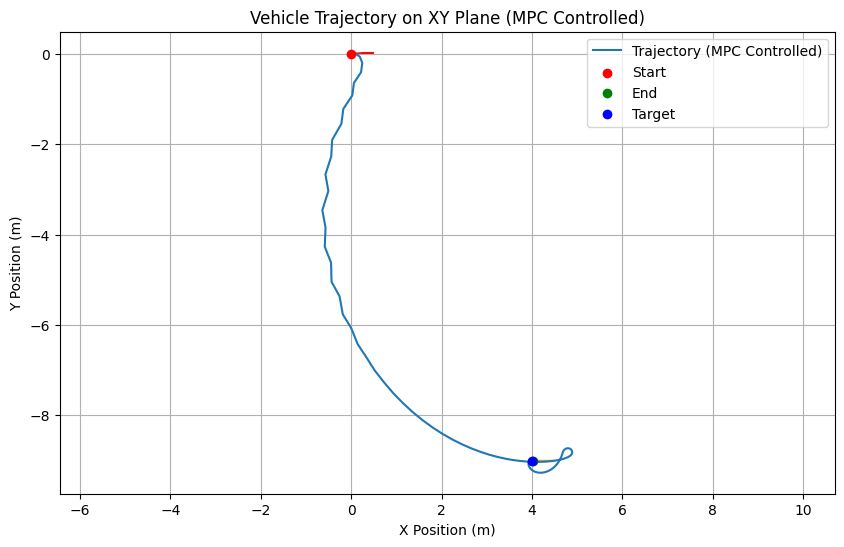

In [7]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
import cvxpy as cp

def get_linear_matrices(v, theta, friction_coefficient):
    """
    Returns linearized A and B matrices for the given velocity (v), heading (theta), and friction coefficient.
    x: [x, y, theta, v]
    u: [u1 (acceleration), u2 (angular velocity)]
    """
    A = np.array([
        [0, 0, -v * np.sin(theta), np.cos(theta)],
        [0, 0, v * np.cos(theta), np.sin(theta)],
        [0, 0, 0, 0],
        [0, 0, 0, -friction_coefficient]
    ])
    B = np.array([
        [0, 0],
        [0, 0],
        [0, 1],
        [1, 0]
    ])
    return A, B

# Parameters
dt = 0.1           # Time step (s)
num_steps = 100     # Number of simulation steps
horizon = 10       # Prediction horizon
friction_coefficient = 0.1  # Friction coefficient

Q = np.diag([1, 1, 0.001, 1])  # State cost
R = np.diag([1, 0.001])          # Control cost

x = np.array([0.0, 0.0, 0.0, 1.0])  # Initial state
x_history = [x[0]]
y_history = [x[1]]



for step in range(num_steps):
    A, B = get_linear_matrices(x[3], x[2], friction_coefficient)
    A_d = expm(A * dt)  # Discretized A matrix

    # MPC Optimization
    x_var = cp.Variable((4, horizon + 1))
    u_var = cp.Variable((2, horizon))

    cost = 0
    constraints = [x_var[:, 0] == x]  # Initial state constraint

    for t in range(horizon):
        cost += cp.quad_form(x_var[:, t] - x_ref, Q) + cp.quad_form(u_var[:, t], R)
        constraints += [x_var[:, t + 1] == A_d @ x_var[:, t] + B @ u_var[:, t]]  # Dynamics constraint
        constraints += [cp.abs(u_var[0, t]) <= 10]  # Acceleration limits
        constraints += [cp.abs(u_var[1, t]) <= np.pi]  # Angular velocity limits

    cost += cp.quad_form(x_var[:, horizon] - x_ref, Q)  # Terminal cost
    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve()

    # Apply first control input
    u = u_var[:, 0].value

    # Update state
    x = A_d @ x + B @ u * dt
    x_history.append(x[0])
    y_history.append(x[1])

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_history, y_history, label="Trajectory (MPC Controlled)")
plt.scatter(x_history[0], y_history[0], color='red', label="Start", zorder=5)  
plt.scatter(x_history[-1], y_history[-1], color='green', label="End", zorder=5)
plt.arrow(x_history[0], y_history[0], np.cos(x[3])*0.5, np.sin(x[3])*0.5, color="red")
plt.arrow(x_ref[0], x_ref[1], np.cos(x_ref[3])*0.5, np.sin(x_ref[3])*0.5, color="orange")
plt.scatter(x_ref[0], x_ref[1], color='blue', label="Target", zorder=5)  
plt.title("Vehicle Trajectory on XY Plane (MPC Controlled)")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.legend()
plt.grid()
plt.axis('equal')
plt.show()

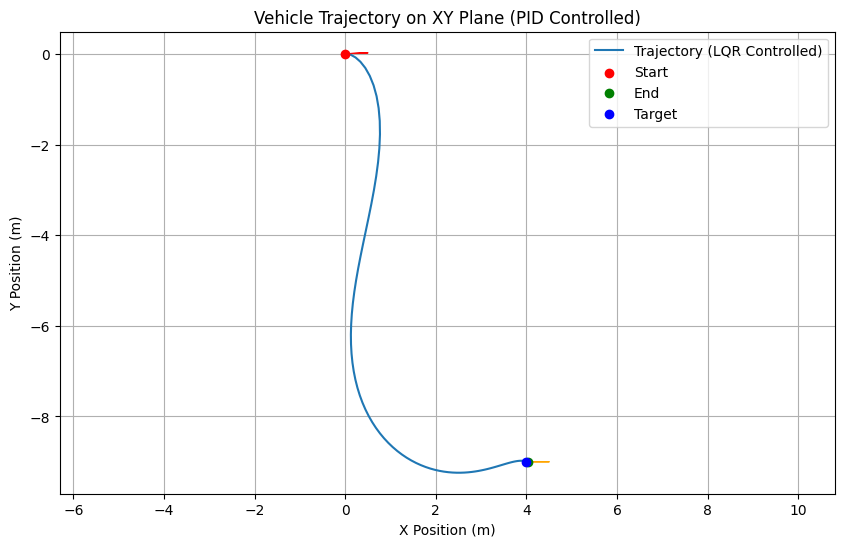

In [8]:
import numpy as np
from scipy.linalg import expm, solve_continuous_are
import matplotlib.pyplot as plt

head_coef_int = 0
head_prev = 0

accel_coef_int = 0
accel_prev = 0
prevX = 0
prevY = 0

def get_linear_matrices(v, theta, friction_coefficient):
    """
    Returns linearized A and B matrices for the given velocity (v), heading (theta), and friction coefficient.
    x: [x, y, theta, v]
    u: [u1 (acceleration), u2 (angular velocity)]
    """
    A = np.array([
        [0, 0, -v * np.sin(theta), np.cos(theta)],
        [0, 0, v * np.cos(theta), np.sin(theta)],
        [0, 0, 0, 0],
        [0, 0, 0, -friction_coefficient]
    ])
    B = np.array([
        [0, 0],
        [0, 0],
        [0, 1],
        [1, 0]
    ])
    return A, B

def lqr(A, B, Q, R):
    """
    Solves the continuous-time Algebraic Riccati Equation (ARE) for LQR.
    Returns the optimal gain matrix K.
    """
    P = solve_continuous_are(A, B, Q, R)
    K = np.linalg.inv(R) @ (B.T @ P)
    return K

def PID(error, coef_int, prev, kp, ki ,kd):
    coef_int += error  # Integral term
    out = error * kp + coef_int * ki + (error - prev) * kd  # PID output
    prev = error  # Update previous error

    return out, coef_int, prev  # Return updated integral and previous values

dt = 0.1          
num_steps = 100   
friction_coefficient = 0.1 

Q = np.diag([1, 1, 0.001, 1])  # State cost
R = np.diag([1, 0.001])          # Control cost      

x = np.array([0.0, 0.0, 0.0, 0.5])
x_history = [x[0]]
y_history = [x[1]]

# x_ref = np.array([np.random.uniform(-10, 10), np.random.uniform(-10, 10), np.random.uniform(-2*np.pi, 2*np.pi), 0]) 

for step in range(num_steps):
    A, B = get_linear_matrices(x[3], x[2], friction_coefficient)
    
    K = lqr(A, B, Q, R)

    dist = ((x_ref[1] - x[1])**2  + (x_ref[0] - x[0])**2)**(1/2)

    #u = -K @ (x - x_ref)
    headingForDist = np.arctan2((x_ref[1] - x[1]) , (x_ref[0] - x[0]))
    heading_error = (headingForDist) - x[2]
    heading, head_coef_int, head_prev = PID(heading_error, head_coef_int, head_prev, 1.2, 0.000, 0.001)

    vel = (((x[0] - prevX)**2 + (x[1] - prevY)**2)**(1/2)/dt)



    vel_error = 1 * (dist / 2.4) - vel
    prevX = x[0]
    prevY = x[1]
    accel, accel_coef_int, accel_prev = PID(vel_error, head_coef_int, head_prev, 0.8, 0.0002, 0.002)


    u = np.array([accel, heading])
    #print(x)
    #print(x_ref)
    # print(vel , vel_error, dist)

    u[0] = np.clip(u[0], -10, 10) 
    u[1] = np.clip(u[1], -np.pi, np.pi) 
    

    A_d = expm(A*dt)
    x = A_d @ x + B @ u * dt 
    
   
    x_history.append(x[0])
    y_history.append(x[1])

plt.figure(figsize=(10, 6))
plt.plot(x_history, y_history, label="Trajectory (LQR Controlled)")
plt.scatter(x_history[0], y_history[0], color='red', label="Start", zorder=5)  
plt.arrow(x_history[0], y_history[0], np.cos(x[3])*0.5, np.sin(x[3])*0.5, color="red")
plt.arrow(x_ref[0], x_ref[1], np.cos(x_ref[3])*0.5, np.sin(x_ref[3])*0.5, color="orange")
plt.scatter(x_history[-1], y_history[-1], color='green', label="End", zorder=5)
plt.scatter(x_ref[0], x_ref[1], color='blue', label="Target", zorder=5)  
plt.title("Vehicle Trajectory on XY Plane (PID Controlled)")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.legend()
plt.grid()
plt.axis('equal')
plt.show()